# Holographic Reconstruction: Skyrmion Lattice

Copyright subsisting in the code is jointly owned by the Centre National de la Recherche Scientifique (CNRS), the University of Exeter and the contributors*. Use of the code is permitted without further consent for recreation of the images from the published data as well as for personal educational use. Any commercial use or research use of the code, including the data processing at synchrotron facilities, in part or in whole, requires prior written permission of the CNRS or the University of Exeter. If permission is granted, you will need to display the appropriate credit or acknowledgement wording, in case of any subsequent dissemination.  
If you have a query regarding such use of the code, contact Prof Feodor Y. Ogrin: f.y.ogrin@exeter.ac.uk
*Contributors: G. Beutier (CNRS), T. A. Duckworth, E. O. Burgos-Parra, N. Bukin, A. Laurenson (previously at the University of Exeter), L. A.  Turnbull (Durham University), F. Y. Ogrin (University of Exeter).

In [1]:
%matplotlib notebook

In [2]:
#### Loads relevant python libraries ####

import h5py as h5
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import scipy as sp
from scipy import ndimage, fftpack, optimize

In [3]:
### Define Functions ###

# Applies differential filter accross the array to remove contribution from the reference slit.  
def d_filter(array, theta, origin):
    x, y = np.meshgrid(np.arange(array.shape[0]), np.arange(array.shape[1]))
    return np.pi * 2.0 * (np.cos(theta) * (x - origin[0]) - np.sin(theta) * (y - origin[1]))

# Optimises the pair of images to equalise the overall intensity to remove non magnetic signals. 
def sep(lefty, righty):
    
    # optimising equalisation of input images to maximise signal to noise ratio, remove non magnetic signals
    def sum_abs_dif_data(ratio):
        return np.sum(np.absolute(lefty[1300:1460, 750:1000] - ratio * righty[1300:1460, 750:1000]))
    
    ratio = sp.optimize.minimize(sum_abs_dif_data, 1).x[0]
    dif_data = lefty - ratio * righty
    sum_data = lefty + righty
    return (dif_data, sum_data, ratio)

# Applies Origin Correction for Fourier Transform
def p_correction(array, origin):
    x, y = np.meshgrid(np.arange(array.shape[0]), np.arange(array.shape[1]))
    return array * np.exp(1j * 2.0 * np.pi * (origin[0] * x / array.shape[0] + origin[1] * y / array.shape[1]))


# Normalises Image to max value
def norm(image):
    return (image) / np.amax(image)

# Loading Left and Right Polarised Scans

In [4]:
# Loads left scan 
with h5.File('scanx_122.nxs', 'r') as f:
    lefty = np.squeeze(f["scanx_122"]["scan_data"]["data_14"])

# Loads right scan 
with h5.File('scanx_123.nxs', 'r') as f:
    righty = np.squeeze(f["scanx_123"]["scan_data"]["data_14"])

<IPython.core.display.Javascript object>


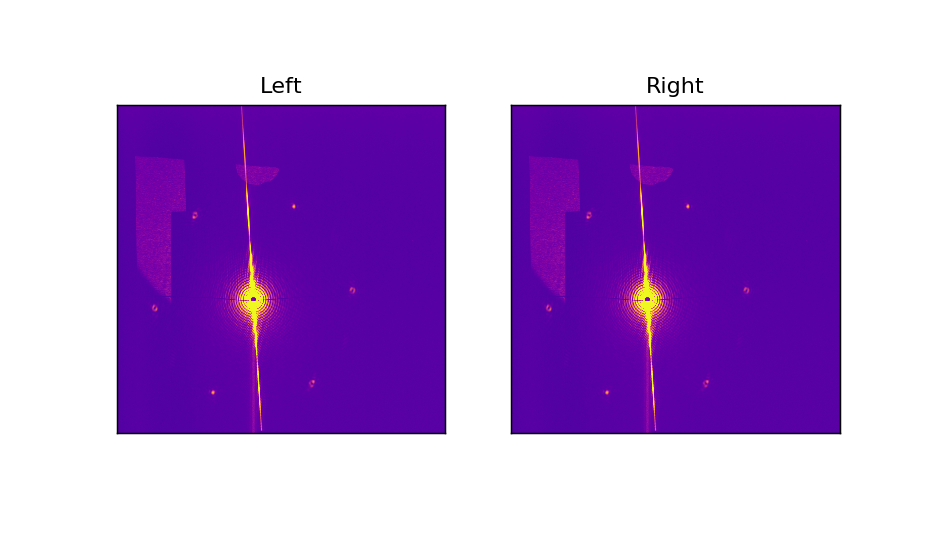

In [5]:
### Plotting Raw Data Scans ###
plt.figure(figsize=(7, 4))

# Plots left polarised data on log scale
ax1=plt.subplot2grid((1, 2), (0, 0), rowspan=1, colspan=1)
plt.imshow(lefty,norm=colors.SymLogNorm(linthresh=1e1),
           interpolation='none', cmap='plasma')
plt.clim(vmax=1e5)
plt.title('Left')
plt.xticks([])
plt.yticks([])

# Plots right polarised data on log scale
ax2=plt.subplot2grid((1, 2), (0, 1), rowspan=1, colspan=1)
plt.imshow(lefty,norm=colors.SymLogNorm(linthresh=1e1),
           interpolation='none', cmap='plasma')
plt.clim(vmax=1e5)
plt.title('Right')
plt.xticks([])
plt.yticks([])

plt.show()

We can see regions of the CCD image where stray light has passed around the sample holder, creating patches of bright light. If these sources of noise are not removed, there will be significant noise in the reconstructed image. Therefore, they are removed below.

In [6]:
# Removes stray light regions from
lefty[1195:1244, 272:342] = 4.32e4
lefty[316:1244, 110:342] = 4.32e4
lefty[328:670, 330:433] = 4.32e4
lefty[371:482, 737:788] = 4.35e4
lefty[374:509, 810:1020] = 4.35e4

# Removes stray light regions from
righty[1195:1244, 272:342] = 4.22e4
righty[316:1244, 110:342] = 4.22e4
righty[328:670, 330:433] = 4.22e4
righty[371:482, 737:788] = 4.25e4
righty[374:509, 810:1020] = 4.25e4

<IPython.core.display.Javascript object>


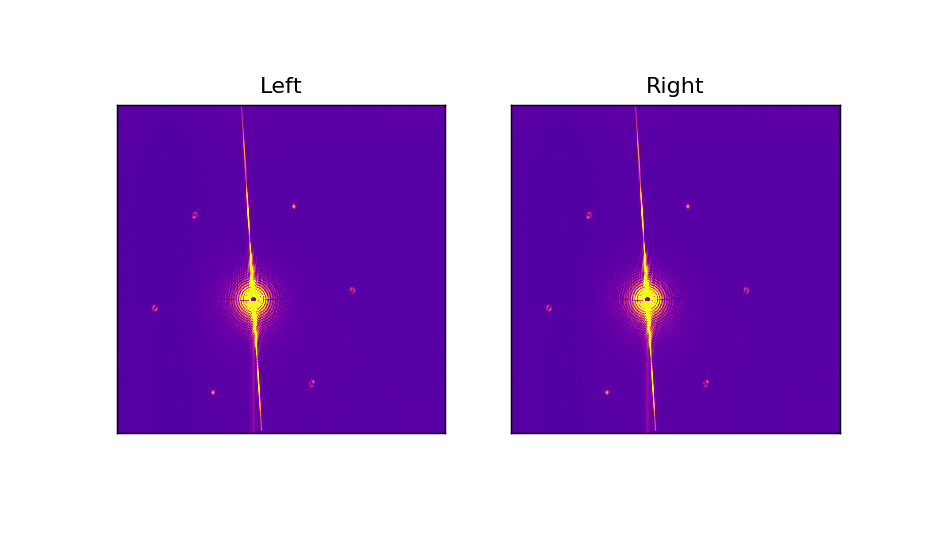

In [7]:
### Plotting Scans Without Stray Light ###
plt.figure(figsize=(7, 4))

# Plots left polarised data on log scale
ax1=plt.subplot2grid((1, 2), (0, 0), rowspan=1, colspan=1)
plt.imshow(lefty,norm=colors.SymLogNorm(linthresh=1e1),
           interpolation ='none', cmap='plasma')
plt.clim(vmax=1e5)
plt.title('Left')
plt.xticks([])
plt.yticks([])

# Plots right polarised data on log scale
ax2=plt.subplot2grid((1, 2), (0, 1), rowspan=1, colspan=1)
plt.imshow(lefty, norm=colors.SymLogNorm(linthresh=1e1),
           interpolation ='none', cmap='plasma')
plt.clim(vmax=1e5)
plt.title('Right')
plt.xticks([])
plt.yticks([])

plt.show()

To ensure proper subtraction of the structural signal, the total intensity of both CCD scans is equalised.

In [8]:
# Function equalises the intensity of both CCD scans and subtracts them, displaying the original ratio 
# of their intensities.
# Magnetic contribution is the subtracton of the left and right images.

magnetic, c, ratio = sep(lefty, righty)
print(ratio)

1.0014266239726166


# Performing Subtraction

To apply the differential filter and remove the effects of the extended reference slit, the origin of the diffraction and angle of the reference slit must be well defined. Problems with reconstruction likely lie with the definition of these variables.

In [9]:
# Define the centre of the diffraction pattern and the angle of the reference slit.
origin = np.array([848.6, 1214.7])
angle = 0.0602

<IPython.core.display.Javascript object>


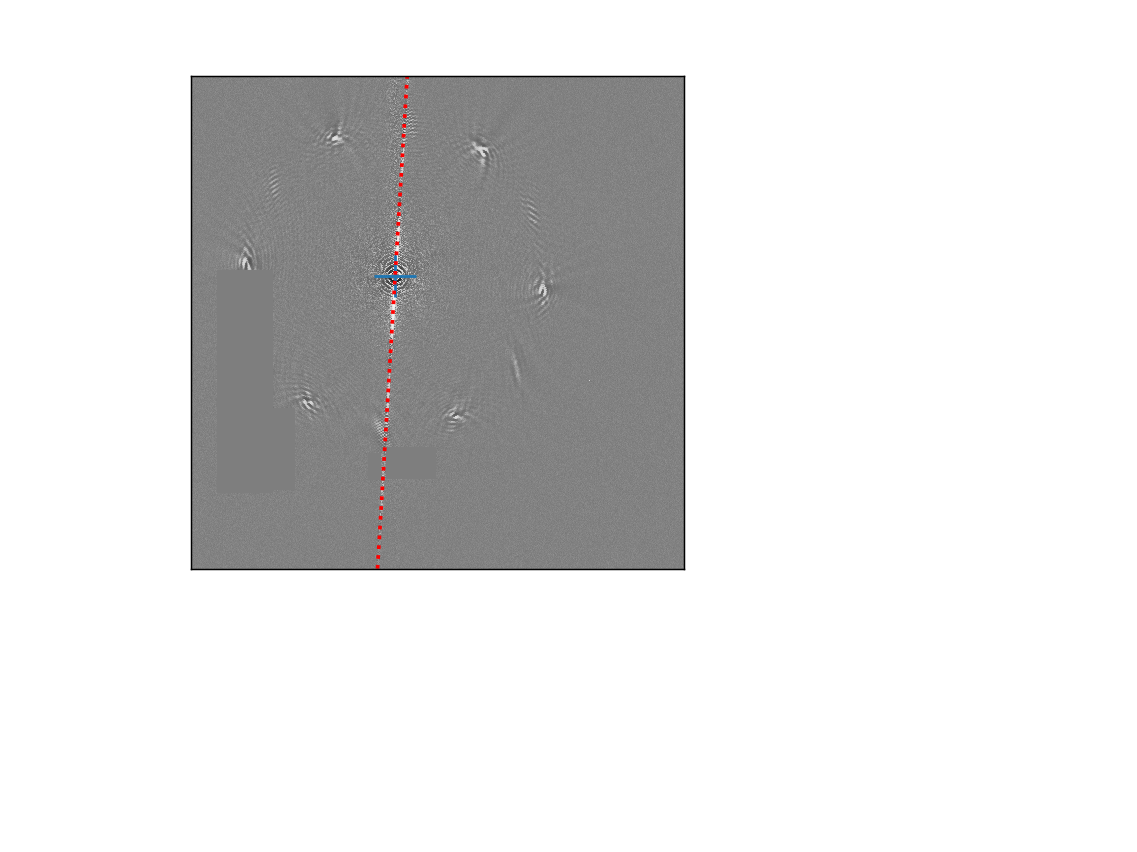

In [10]:
# Plotting the magnetic signal, with the origin position and angle of the slit shown.

plt.figure()
# Plots the subtracted CCD magnetic signal
plt.imshow(magnetic,norm=colors.SymLogNorm(linthresh=1000),
           interpolation='none',
           cmap='Greys')

# Plot defined origin of diffraction
plt.scatter(origin[0], origin[1], s=500, marker='+')

# Plot defined angle of reference slit scattering
plt.plot(np.tan(angle) * np.arange(magnetic.shape[0]) + origin[0] - np.tan(angle) * origin[1],
         np.arange(magnetic.shape[0]),
         linestyle=':', color='r', linewidth=2)
plt.xlim(0,magnetic.shape[0]),
plt.ylim(0,magnetic.shape[1])
plt.xticks([])
plt.yticks([])

plt.show()

With the strucutal component of the diffraction removed by the subtracton of the two oppositely polarised scans, the magnetic contribution is now easily seen. Areas of stray light which were removed previously are visible. Now the convolution from the extended reference slit must be removed. This is done by applying a differential filter to the subtracted CCD scans before the fourier transform is performed.

<IPython.core.display.Javascript object>


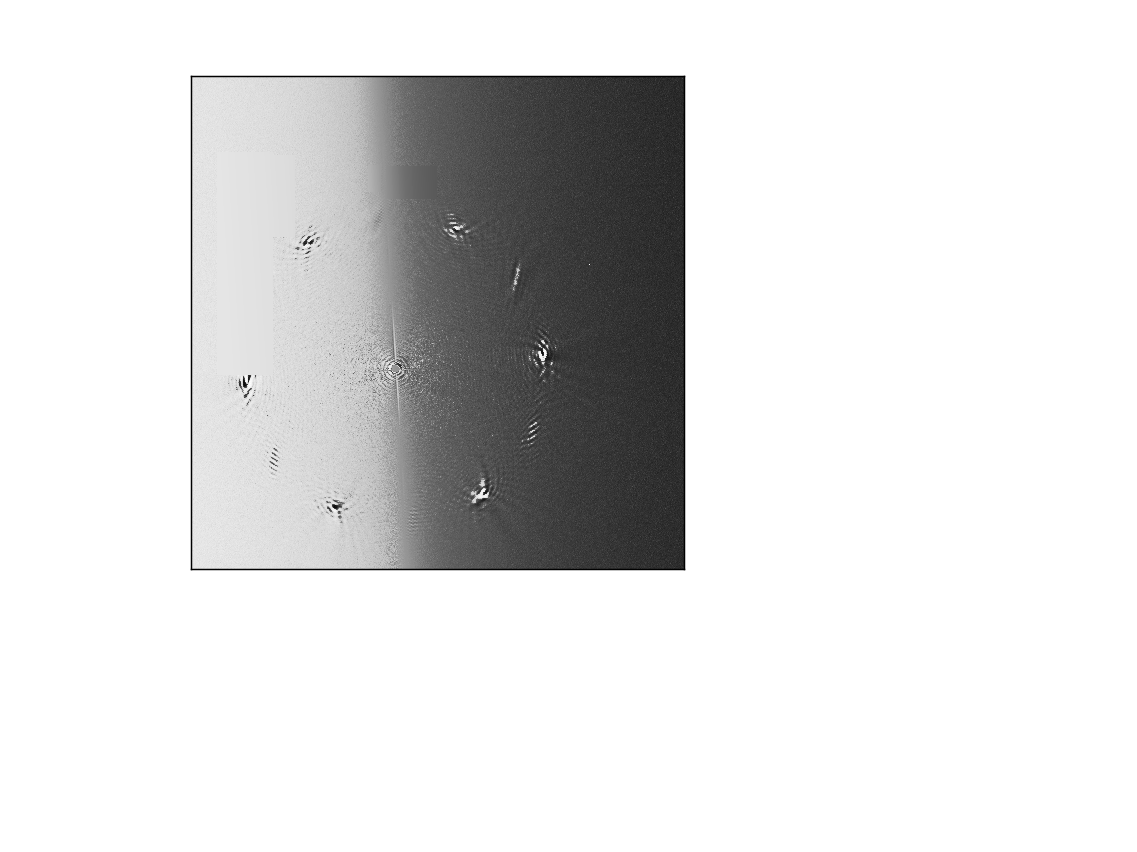

In [11]:
# Applies differential filter accross magnetic array to remove slit contribution.
filtered = magnetic * d_filter(magnetic, angle, origin)

# Plots figure of this filtered magnetic CCD image. 
plt.figure()
plt.imshow(filtered, norm=colors.SymLogNorm(linthresh=500000),
           interpolation='none',
           cmap='Greys')
plt.xticks([])
plt.yticks([])
plt.show()

# Performing Fourier Transform Reconstruction

In [12]:
transformed_mag = sp.fftpack.fftshift(sp.fftpack.fft2(filtered))  # Fourier Transform
corrected_mag = p_correction(transformed_mag, origin)             # Makes Fourier transform about origin
image = norm(corrected_mag)                                       # Normalise image

<IPython.core.display.Javascript object>


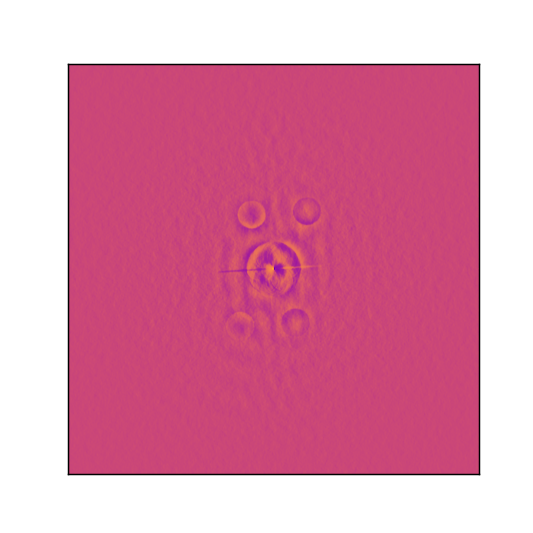

In [13]:
### Plotting the Fourier transformed image ###

# Selects phase of hologram.
images = np.real(np.exp(0j * 1.8) * image)

# Plots the filtered image on a log scale.
plt.figure(figsize=(4, 4))
plt.imshow(sp.ndimage.gaussian_filter((images), 0),
           norm=colors.SymLogNorm(linthresh=1e-4),
           interpolation='bicubic',          
           cmap='plasma')
plt.clim(vmin=-0.05, vmax=0.05)
plt.xticks([])
plt.yticks([])

plt.show()

The above image shows the full reconstructed hologram. The centre signal is the autocorrelation, consisting of all objects convolved together. Around this, the 4 sample images can be seen, formed by either end of the reference slit.

# Selecting the Reconsructed Image Phase

The resultant images can be multiplied by a phase angle.

<IPython.core.display.Javascript object>


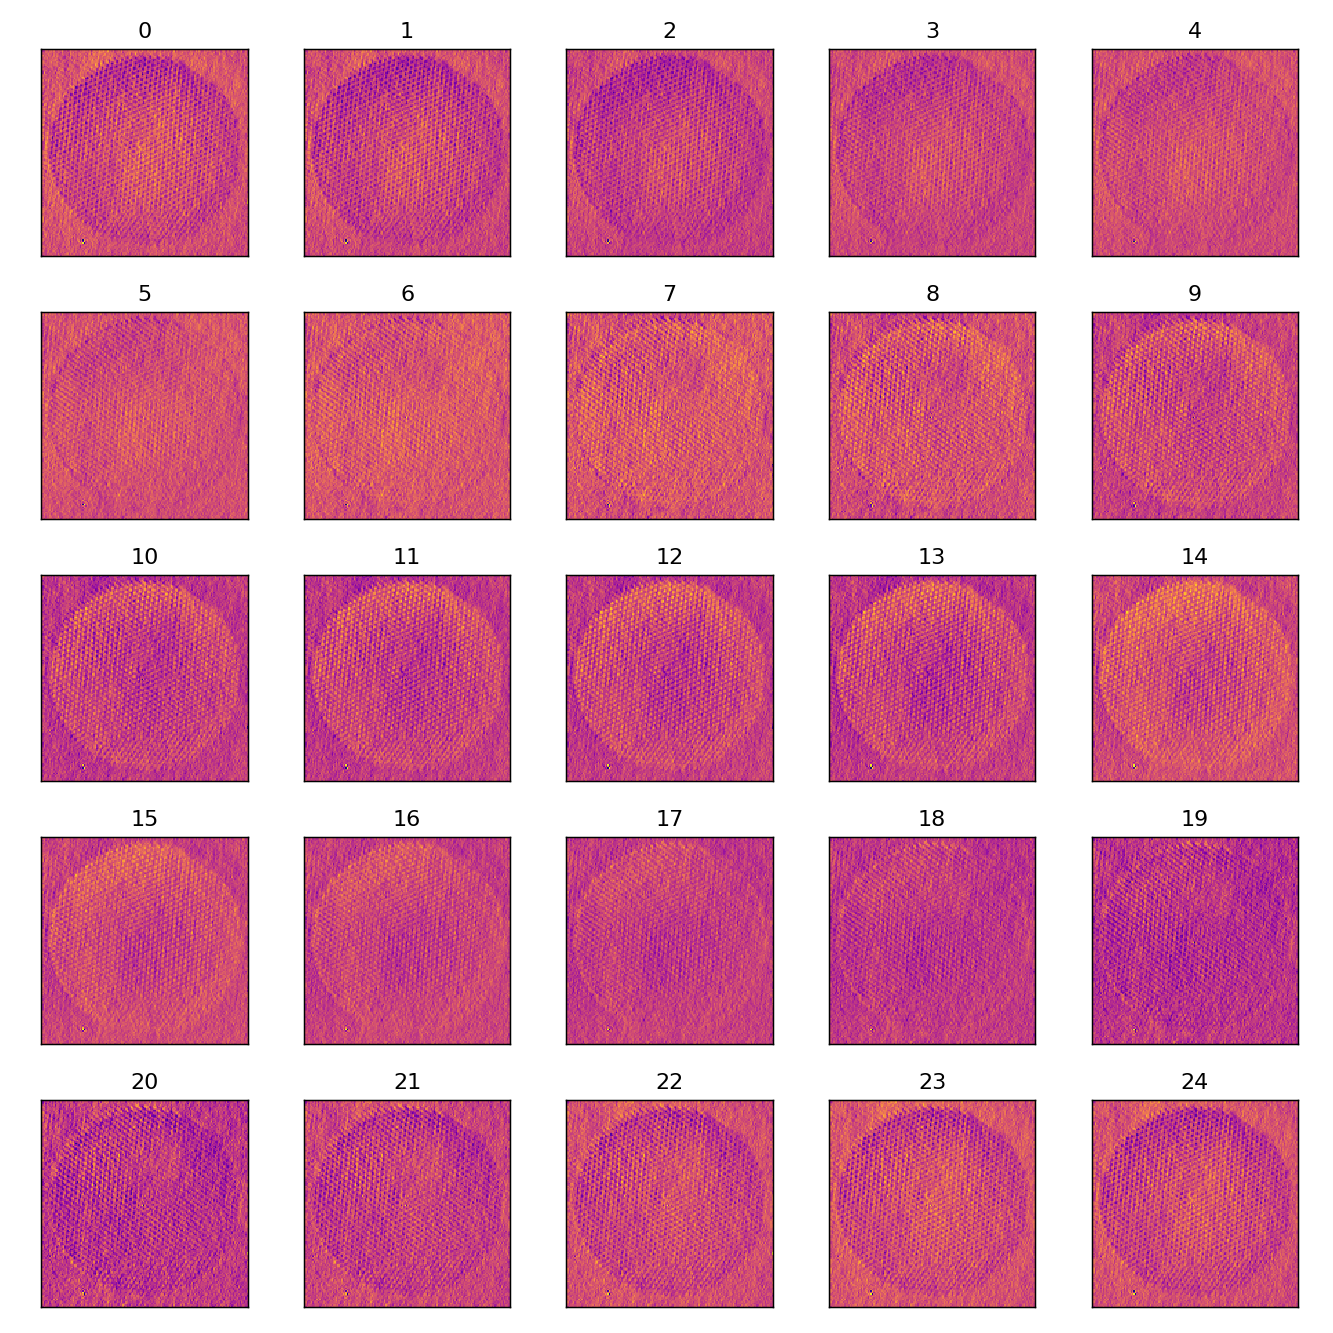

In [14]:
### Plots zoomed in views of one of the image reconstructions at different phases ###

# Selects cropped area of reconstruction.
ima = norm(image[662:812, 1115:1265])

# Defines the number of different phases to try
number = 25

plt.figure(figsize=(10, 10))

tup = []
# Loops to create subplot coordinates
for i in np.arange(0, 5, 1):
        for j in np.arange(0, 5, 1):
            tup.append((i, j))
            
# Plots the same image at different phases.
for i in np.arange(0, number, 1):
    ax1 = plt.subplot2grid((5, 5), tup[i], rowspan=1, colspan=1)
    # Sets phase angle of each image
    angle = np.exp(1j * (i * 2 * np.pi / number))
    plt.imshow(sp.ndimage.gaussian_filter(np.real(angle * ima), 0.5),
               interpolation='none',
               origin='lower',
               cmap='plasma')
    ax1.set_title(str(i))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
#plt.savefig('Compare_SkL.png')

The different phase images can be inspected to choose the best reconstruction. We decided to choose the first phase angle of 0 in this instance.

# Filtering and Masking

In [15]:
# Performs background filter subtraction and normalises the image.
raw = np.real(np.exp(0j) * ima)
background = sp.ndimage.gaussian_filter(raw, 2)
a = raw - background
mag = (a - np.amin(a)) / np.amax(a) - 1
mag = mag / np.amax(mag)

In [16]:
# Applies a partial mask to the surrounding non-magnetic region of the reconstructed image.
raw = np.real(np.exp(0j) * ima)
lx, ly = 150, 150
X, Y = np.ogrid[0:lx, 0:ly]
mask = (X - lx / 2) ** 2 + (Y - ly / 2) ** 2 > lx * ly / 5

# Masks
mag[mask] = 0.5 * mag[mask]

# Final Reconstructed Image

<IPython.core.display.Javascript object>


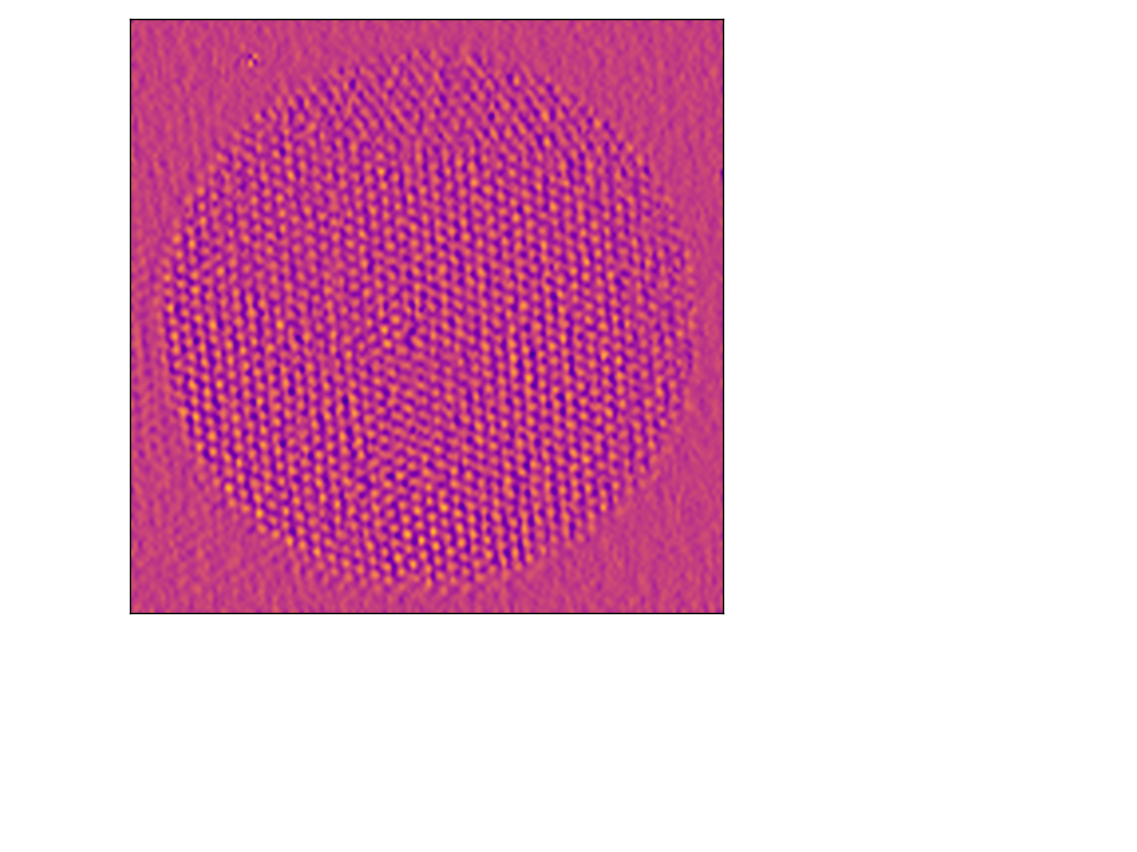

In [17]:
# Plots final recontructed holographic image

plt.figure()
plt.imshow(sp.ndimage.gaussian_filter(mag, 0.25),
           interpolation='bicubic', cmap='plasma_r', extent=[0, 3, 0, 3])
plt.clim(vmin=-0.3, vmax=0.3)
plt.xticks([])
plt.yticks([])
plt.tight_layout()

plt.show()
#np.savetxt("skyrmions.csv", mag, delimiter=",")